# Project 2 - UTA and AHP Methods

## Imports

In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 41.6 MB/s eta 0:00:00


In [2]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import networkx as nx

## UTA

This section concerned with the implementation of the UTA method for both finding the minimal subset of consistent preferences among pairwise comparisons and implementing the solver to find appropriate values for the considered criteria values to create marginal value functions, these values are later used to calculate comprehensive preference values, allowing for comparison of the preferences.

### Data

Please note, that the original dataset had to be slightly modified by changing the spaces in the names of games to _ signs in order to avoid warnings when creating PuLP variables.

In [3]:
data = pd.read_csv("data.csv")
data["name"] = data["name"].str.replace(" ", "_")
data

,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark_Souls:_Remastered,150,84,83,44,11,41
1,Dark_Souls_III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's_Gate_3,250,96,89,107,8,54
4,Dave_the_Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow_Knight,68,90,91,42,10,63
7,Portal_2,46,95,89,14,7,51
8,Vampire_Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


The original pairwise preference information has been included below:

* Payday 3 < Titan Souls
* Kao the Kangaroo < Hades
* Subnautica < Terraria
* Assassin's Creed Unity < Dark Souls: Remastered

This set of comparisons is too poor to produce interesting results, it also does not include any inconsistencies, as such it has been enriched with new preferences as can be seen in the code cell below. These preferences also include inconsistencies like:

* Assasin's Creed Unity < Dark Souls Remastered
* Dark Souls Remastered < Terraria
* Terraria < Assasin's Creed Unity

In [4]:
preferences = ["Payday_3 < Titan_Souls",
               "Kao_the_Kangaroo < Hades",
               "Subnautica < Terraria",
               "Assassin's_Creed_Unity < Dark_Souls:_Remastered",
               "Dark_Souls:_Remastered < Terraria",
               "Terraria < Assassin's_Creed_Unity",
               "Dark_Souls_III < Skyrim",
               "The_Sims_3 < Dark_Souls_III",
               "The_Sims_3 < Baldur's_Gate_3",
               "Subnautica < Baldur's_Gate_3",
               "Kao_the_Kangaroo < Dishonored",
               "Teardown < Dying_Light",
               "Trials_Fusion < Skyrim",
               "Hollow_Knight > Rust",
               "Baldur's_Gate_3 > Rust",
               "Hades > Assassin's_Creed_Unity"]

criteria_types = {"price": "cost", "critic_score" : "gain", "user_score" : "gain", "length" : "gain", "genres" : "gain", "num_of_achievements" : "gain"}

### Implementation

Please note that in the below implementation a value of epsilon appears, it is here mostly because PuLP does not support strict inequality, but something similar can be achieved by using epsilon on one of the variables, additionally, rounding may appear in some places due to possibility of numerical errors.

In [5]:
def get_split_sign(preference):
    '''
    Given a string representing a preference, returns the sign representing the relationship between variables.
    Possible signs: <, >, =, <=, >=.
    Parameters:
        preference (str): Preference information.
    '''
    if "<" in preference:
        return "<"
    elif ">" in preference:
        return ">"
    elif "=" in preference:
        return "="
    elif "<=" in preference:
        return "<="
    elif ">=" in preference:
        return ">="
    else:
        raise ValueError("Unexpected or lack of sign indicating preference")

def get_condition(preference, split_sign):
    '''
    Returns alternatives and the relationship between them.
    Parameters:
        preference (str): Preference information.
        split_sign (str): sign representing type of preference
    '''
    parts = preference.split(split_sign)
    parts = [part.strip() for part in parts]
    return parts[0], split_sign, parts[1]

def add_error_variables(var, compared_alternatives, positive_errors, negative_errors):
    '''
    Adds error variables- positive and negative (over or underestimation) errors for a given problem
    Parameters:
        var (str): Variable name for which error variables need to be added.
        compared_alternatives (set): Set containing the names of compared alternatives.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
    '''
    if var not in compared_alternatives:
        compared_alternatives.add(var)
        positive_errors[var] = pulp.LpVariable(f'positive_error_{var}', lowBound=0)
        negative_errors[var] = pulp.LpVariable(f'negative_error_{var}', lowBound=0)

def get_alternative_constraints(alternatives):
    '''
    Creates variables for all constraint values.
    Parameters:
        alternatives (pandas.DataFrame): DataFrame containing alternatives and their criteria values.
    '''
    alternative_constraints = {}
    alt_constraint_names = {}
    for i, row in alternatives.iterrows():
        alternative_constraints[row["name"]] = {}
        for col in alternatives.drop(columns = ["name"]).columns:
            if f'{col}_{row[col]}' not in list(alt_constraint_names.keys()):
                alternative_constraints[row["name"]][col] = pulp.LpVariable(f'{col}_{row[col]}', lowBound=0)
                alt_constraint_names[f'{col}_{row[col]}'] = (row["name"], col)
            else:
                temp_name = alt_constraint_names[f'{col}_{row[col]}'][0]
                temp_col = alt_constraint_names[f'{col}_{row[col]}'][1]
                alternative_constraints[row["name"]][col] = alternative_constraints[temp_name][temp_col]
    return alternative_constraints

def get_comparison_constrains(alternative_constraints, var_names, positive_errors, negative_errors):
    '''
    Creates constraints based on preference infromation given by the DM.

    Parameters:
        alternative_constraints (dict): Variables for all alternatives values.
        var_names (list): Variable names and comparison conditions.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
    '''
    constraints = []
    epsilon = 1e-5
    for alt_name_1, condition, alt_name_2 in var_names:
        expression1 = negative_errors[alt_name_1] - positive_errors[alt_name_1] + pulp.lpSum(alternative_constraints[alt_name_1][key] for key in alternative_constraints[alt_name_1].keys())
        expression2 = negative_errors[alt_name_2] - positive_errors[alt_name_2] + pulp.lpSum(alternative_constraints[alt_name_2][key] for key in alternative_constraints[alt_name_1].keys())
        if condition == ">=":
            new_constraint = expression1 >= expression2
        elif condition == ">":
            new_constraint = expression1 >= expression2 + epsilon
        elif condition == "=":
            new_constraint = expression1 == expression2
        elif condition == "<=":
            new_constraint = expression1 <= expression2
        elif condition == "<":
            new_constraint = expression1 + epsilon <= expression2
        constraints.append(new_constraint)
    return constraints

def get_normalization_constrains(constraints, alternatives, criteria_types, alternative_constraints):
    '''
    Creates UTA constraints for normalization.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        alternative_constraints (dict): Constraints of alternatives
    '''
    best_row_positions = []
    for criteria in criteria_types.keys():
        if criteria_types[criteria] == "cost":
            idx = alternatives[criteria].idxmin()
        elif criteria_types[criteria] == "gain":
            idx = alternatives[criteria].idxmax()
        row = alternatives.loc[idx]
        best_row_positions.append([row["name"], criteria])
    constraints.append(pulp.lpSum(alternative_constraints[name][crit] for name, crit in best_row_positions) == 1.0)

    worst_row_positions = []
    for criteria in criteria_types.keys():
        if criteria_types[criteria] == "cost":
            idx = alternatives[criteria].idxmax()
        elif criteria_types[criteria] == "gain":
            idx = alternatives[criteria].idxmin()
        row = alternatives.loc[idx]
        worst_row_positions.append([row["name"], criteria])
    for name, crit in worst_row_positions:
        constraints.append(alternative_constraints[name][crit] == 0.0)
    return constraints

def get_monotonicity_constrains(constraints, alternatives, criteria_types, alternative_constraints):
    '''
    Creates UTA monotonicity contraints.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        alternative_constraints (dict): Constraints of alternatives
    '''
    for col in alternatives.drop(columns = ["name"]).columns:
        if criteria_types[col] == "gain":
            alternatives.sort_values(by=col, inplace=True)
        if criteria_types[col] == "cost":
            alternatives.sort_values(by=col, inplace=True, ascending=False)
        alternatives.reset_index(drop=True, inplace=True)
        prev_val = alternatives[col][0]
        for i in range(1, len(alternatives[col])):
            constraints.append(alternative_constraints[alternatives["name"][i-1]][col] <= alternative_constraints[alternatives["name"][i]][col])
    return constraints

def get_threshold_constraints(constraints, alternatives, alternative_constraints, upper_threshold, lower_threshold):
    '''
    Creates UTA cosntraints for specified threshold values - lower and upper.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        alternative_constraints (dict): Dictionary of PuLP variables.
        upper_threshold (float): Upper threshold weight for criteria.
        lower_threshold (float): Lower threshold weight for criteria.
    '''
    for name in alternative_constraints.keys():
        for col in alternative_constraints[name].keys():
            constraints.append(alternative_constraints[name][col] <= upper_threshold)
    for col in alternatives.drop(columns = ["name"]).columns:
        if criteria_types[col] == "gain":
            alternatives.sort_values(by=col, inplace=True, ascending=False)
        if criteria_types[col] == "cost":
            alternatives.sort_values(by=col, inplace=True)
        alternatives.reset_index(drop=True, inplace=True)
        constraints.append(alternative_constraints[alternatives["name"][0]][col] >= lower_threshold)
    return constraints

def define_LP_problem(alternatives, criteria_types, var_names, positive_errors, negative_errors, upper_threshold, lower_threshold):
    '''
    Defines the Linear Programming (LP) problem for the UTA method.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        var_names (list): Variable names and comparison conditions.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
        upper_threshold (float): Upper threshold weight for criteria.
        lower_threshold (float): Lower threshold weight for criteria.
    '''
    F = pulp.lpSum(positive_errors.values()) + pulp.lpSum(negative_errors.values())
    alternative_constraints = get_alternative_constraints(alternatives)
    constraints = get_comparison_constrains(alternative_constraints, var_names, positive_errors, negative_errors)
    constraints = get_normalization_constrains(constraints, alternatives, criteria_types, alternative_constraints)
    constraints = get_monotonicity_constrains(constraints, alternatives.copy(), criteria_types, alternative_constraints)
    constraints = get_threshold_constraints(constraints, alternatives.copy(), alternative_constraints, upper_threshold, lower_threshold)
    problem = pulp.LpProblem('UTA_Problem', pulp.LpMinimize)
    problem += F
    for constraint in constraints:
        problem += constraint
    return problem

def get_binary_variables(var_names):
    '''
    Creates binary variables for pairwise comparisons.
    Parameters:
        var_names (list): List containing variable names and comparison conditions.
    '''
    vars = {}
    for var1, condition, var2 in var_names:
        new_var = pulp.LpVariable(f'v_{var1}_{var2}', cat='Binary')
        vars[f"{var1}_{var2}"] = new_var
    return vars

def get_comparison_comprehensive_vars(var_names):
    '''
    Creates comprehensive variables for pairwise comparisons.

    Parameters:
        var_names (list): List containing variable names and comparison conditions.
    '''
    existing_vars = set()
    vars_dict = {}
    for var1, condition, var2 in var_names:
        if var1 not in existing_vars:
            existing_vars.add(var1)
            vars_dict[var1] = pulp.LpVariable(f'U_{var1}', lowBound=0)
        if var2 not in existing_vars:
            existing_vars.add(var2)
            vars_dict[var2] = pulp.LpVariable(f'U_{var2}', lowBound=0)
    return vars_dict

def get_comparison_comprehensive_constraints(var_names, comprehensive_vars, binary_vars):
    '''
    Creates UTA constraints for subset detection based on user preference information.

    Parameters:
        var_names (list): List containing variable names and comparison conditions.
        comprehensive_vars (dict): Comprehensive variables with pairwise comparisons.
        binary_vars (dict): Binary variables showing preference
    '''
    constraints = []
    epsilon = 1e-5
    for var1, condition, var2 in var_names:
        if condition == "<":
            constraints.append(comprehensive_vars[var1] - binary_vars[f"{var1}_{var2}"] + epsilon <= comprehensive_vars[var2])
        elif condition == ">":
            constraints.append(comprehensive_vars[var1] >= comprehensive_vars[var2] - binary_vars[f"{var1}_{var2}"] + epsilon)
        elif condition == "=":
            constraints.append(comprehensive_vars[var1] >= comprehensive_vars[var2] - binary_vars[f"{var1}_{var2}"])
            constraints.append(comprehensive_vars[var1] - binary_vars[f"{var1}_{var2}"] <= comprehensive_vars[var2])
    return constraints

def get_comprehensive_norm_constraints(constraints, comprehensive_vars):
    '''
    Creates UTA constraints for normalization when detecting a subset of valid preferences.

    Parameters:
        constraints (list): Existing UTA constraints.
        comprehensive_vars (dict): Comprehensive variables with pairwise comparisons.
    '''
    for key in comprehensive_vars.keys():
        constraints.append(comprehensive_vars[key] <= 1.0)
    return constraints

def get_additional_subset_constraints(constraints, binary_vars, additional_constraints):
    '''
    Creates UTA constraints for choosing which invalid subset was already detected in previous iteration.

    Parameters:
        constraints (list): Existing UTA constraints.
        binary_vars (dict): Binary variables showing preference
        additional_constraints (list): Ddditional constraints to be added.
    '''
    temp_binary_vars = {}
    for key in binary_vars:
        temp_binary_vars["v_" + key.replace(" ", "_")] = binary_vars[key]
    for additional_constraint_set in additional_constraints:
        new_constraint = pulp.lpSum(temp_binary_vars[additional_constraint] for additional_constraint in additional_constraint_set) <= len(additional_constraint_set)-1
        constraints.append(new_constraint)
    return constraints

def find_consistent_subset(preferences, verbose = True, find_new_subset = False, additional_constraints = []):
    '''
    Finds a consistent subset of preferences in UTA using PuLP functions.

    Parameters:
        preferences (list): List of preferences.
        verbose (bool, optional): If verbose information should be printed, Default: True
        find_new_subset (bool, optional): If a new subset with additional constraints should be found. Default: False.
        additional_constraints (list, optional): Additional constraints to be applied. Default: []
    '''
    var_names = []
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names.append([var1, condition, var2])
    binary_vars = get_binary_variables(var_names)
    comprehensive_vars = get_comparison_comprehensive_vars(var_names)
    constraints = get_comparison_comprehensive_constraints(var_names, comprehensive_vars, binary_vars)
    constraints = get_comprehensive_norm_constraints(constraints, comprehensive_vars)
    if find_new_subset:
        constraints = get_additional_subset_constraints(constraints, binary_vars, additional_constraints)
    V = pulp.lpSum(binary_vars.values())
    problem = pulp.LpProblem('Valid_Subset', pulp.LpMinimize)
    problem += V
    for constraint in constraints:
        problem += constraint
    problem.solve()
    if verbose:
        print("\n___________________Problem Definition________________________\n")
        print(problem)
        print("\n")
    if verbose:
        print("\n_________________________Solution____________________________\n")
        print(f"Optimal Objective Function Value = {pulp.value(problem.objective)}")
        print("\n_________________________Variables___________________________\n")
        for var in problem.variables():
            print(f"Variable {var.name}: {var.varValue}")
    inconsistent_subset = []
    for var in problem.variables():
        if round(var.varValue, 5) == 1.0 and str(var.name)[0] == "v": #To avoid numerical errors
            inconsistent_subset.append(var.name)
    return inconsistent_subset

def revise_preferences(var_names_dict, inconsistent_subset):
    '''
    Finds revised preferences based on given inconsistent subset.

    Parameters:
        var_names_dict (dict): Variable names for preferences.
        inconsistent_subset (list): Inconsistent Subset
    '''
    temp_preferences = []
    for preference in preferences:
        add = True
        for subset in inconsistent_subset:
            if var_names_dict[preference][0].replace(" ", "_") in subset and var_names_dict[preference][-1].replace(" ", "_") in subset:
                add = False
                break
        if add:
            temp_preferences.append(preference)
    return temp_preferences

def find_all_consistent_subsets(preferences, verbose_subset = False, verbose_all_subsets = True):
    '''
    Finds all consistent subsets of preferences.

    Parameters:
        preferences (list): List of preferences specified by DM.
        verbose_subset (bool, optional): If response for each subset should be printed. Default: False
        verbose_all_subsets (bool, optional): If response for the whole procedure should be printed. Default: True

    Returns:
        list: Largest subset of consistent preferences.
    '''
    revised_preferences = []
    var_names_dict = {}
    additional_constraints = []
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names_dict[preference] = (var1, condition, var2)
    inconsistent_subset = find_consistent_subset(preferences, verbose_subset)
    additional_constraints.append(inconsistent_subset)
    temp_preferences = revise_preferences(var_names_dict, inconsistent_subset)
    revised_preferences.append(temp_preferences)
    while True:
        inconsistent_subset = find_consistent_subset(preferences, verbose_subset, find_new_subset = True, additional_constraints = additional_constraints)
        if len(inconsistent_subset) == 0:
            break
        additional_constraints.append(inconsistent_subset)
        temp_preferences = revise_preferences(var_names_dict, inconsistent_subset)
        revised_preferences.append(temp_preferences)
    solution = max(revised_preferences, key=len)
    if verbose_all_subsets:
        print("\n______________All Consistent Subsets___________________\n")
        print(revised_preferences)
        print("\n_________________Largest subset of Consistent Preferences_________________\n")
        print(solution)
    return solution

def plot_functions(alternatives, problem):
    '''
    Plots the marginal value function for each criterion.
    '''
    var_values = {}
    min_val = 1.0
    max_val = 0.0
    for var in problem.variables():
        var_values[str(var.name)] = var.varValue
        if var.varValue > max_val:
            max_val = var.varValue
        if var.varValue < min_val:
            min_val = var.varValue
    num_cols = len(alternatives.columns)-1
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4*num_rows))
    fig.suptitle('UTA Marginal Value Function Plots', fontsize=16)
    for i, col in enumerate(alternatives.drop(columns=["name"]).columns):
        row = i // 2
        col_index = i % 2
        x_vals = list(sorted(set(alternatives[col])))
        y_vals = [var_values[f"{col}_{val}"] for val in x_vals]
        for z in range(len(y_vals)):
            y_vals[z] = round(y_vals[z], 3) #Get rid of approximation errors

        axes[row, col_index].plot(x_vals, y_vals, linestyle='-', linewidth=2)
        axes[row, col_index].set_title(f"Marginal Values for {col}")
        axes[row, col_index].set_xlabel(col)
        axes[row, col_index].set_ylabel('marginal value')
        axes[row, col_index].grid(True)
        axes[row, col_index].set_xlim(min(x_vals), max(x_vals))
        axes[row, col_index].set_ylim(0.9*min_val, 1.1*max_val)
    plt.tight_layout()
    plt.show()


def calculate_results(alternatives, problem):
    '''
    Calculates the results.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives.
        problem (pulp.LpProblem): UTA problem as a PuLP class instance.
    '''
    var_values = {}
    result = {}
    for var in problem.variables():
        var_values[str(var.name)] = var.varValue
    for i, row in alternatives.iterrows():
        result[row["name"]] = 0.0
        for col in alternatives.drop(columns = ["name"]).columns:
            result[row["name"]] += var_values[f"{col}_{row[col]}"]
        result[row["name"]] = round(result[row["name"]], 5) #To avoid numerical errors
    sorted_results = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return sorted_results

def solve_UTA(alternatives, criteria_types, preferences, verbose = True, plot_results = True, upper_threshold = 0.5, lower_threshold = 0.05):
    '''
    Solves the UTA method for given alternatives and preferences.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives.
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        preferences (list): List of preferences specified by DM.
        verbose (bool, optional): If verbose information should be printed, Default: True
        plot_results (bool, optional): If results should be plotted (Marginal Value Functions), Default: True
        upper_threshold (float): Upper threshold weight for criteria, default: 0.5
        lower_threshold (float): Lower threshold weight for criteria, default: 0.05
    '''
    var_names = []
    compared_alternatives = set()
    positive_errors = {}
    negative_errors = {}
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names.append([var1, condition, var2])
        add_error_variables(var1, compared_alternatives, positive_errors, negative_errors)
        add_error_variables(var2, compared_alternatives, positive_errors, negative_errors)
    problem = define_LP_problem(alternatives, criteria_types, var_names, positive_errors, negative_errors, upper_threshold, lower_threshold)
    if verbose:
        print("\n___________________Problem Definition________________________\n")
        print(problem)
        print("\n")
    problem.solve()
    if verbose:
        print("\n_________________________Solution____________________________\n")
        print(f"Optimal Objective Function Value = {pulp.value(problem.objective)}")
        print("\n_________________________Variables___________________________\n")
        for var in problem.variables():
            print(f"Variable {var.name}: {var.varValue}")
    if plot_results:
        print("\n_________________________Plots________________________________\n")
        plot_functions(alternatives, problem)
    result = calculate_results(alternatives, problem)
    return result

### Finding Largest Consistent Subset

We can use the defined functions to try and find a consistent subset of preferences based on the originally passed inconsistent preferences. As such, the result will be an optimal objective function value of more than 0.0 since at least one constraint will need to be removed.

In [6]:
find_consistent_subset(preferences)


___________________Problem Definition________________________

Valid_Subset:
MINIMIZE
1*v_Assassin's_Creed_Unity_Dark_Souls:_Remastered + 1*v_Baldur's_Gate_3_Rust + 1*v_Dark_Souls:_Remastered_Terraria + 1*v_Dark_Souls_III_Skyrim + 1*v_Hades_Assassin's_Creed_Unity + 1*v_Hollow_Knight_Rust + 1*v_Kao_the_Kangaroo_Dishonored + 1*v_Kao_the_Kangaroo_Hades + 1*v_Payday_3_Titan_Souls + 1*v_Subnautica_Baldur's_Gate_3 + 1*v_Subnautica_Terraria + 1*v_Teardown_Dying_Light + 1*v_Terraria_Assassin's_Creed_Unity + 1*v_The_Sims_3_Baldur's_Gate_3 + 1*v_The_Sims_3_Dark_Souls_III + 1*v_Trials_Fusion_Skyrim + 0
SUBJECT TO
_C1: U_Payday_3 - U_Titan_Souls - v_Payday_3_Titan_Souls <= -1e-05

_C2: - U_Hades + U_Kao_the_Kangaroo - v_Kao_the_Kangaroo_Hades <= -1e-05

_C3: U_Subnautica - U_Terraria - v_Subnautica_Terraria <= -1e-05

_C4: U_Assassin's_Creed_Unity - U_Dark_Souls:_Remastered
 - v_Assassin's_Creed_Unity_Dark_Souls:_Remastered <= -1e-05

_C5: U_Dark_Souls:_Remastered - U_Terraria - v_Dark_Souls:_Rem

["v_Assassin's_Creed_Unity_Dark_Souls:_Remastered"]

We can also use the predefined functions to find all consistent subsets of preferences achieved by removing as few preferences as possible, in the end we also choose one of them to be the revised list of preferences which can later be passed to the UTA method.

In [7]:
revised_preferences = find_all_consistent_subsets(preferences)


______________All Consistent Subsets___________________

[['Payday_3 < Titan_Souls', 'Kao_the_Kangaroo < Hades', 'Subnautica < Terraria', 'Dark_Souls:_Remastered < Terraria', "Terraria < Assassin's_Creed_Unity", 'Dark_Souls_III < Skyrim', 'The_Sims_3 < Dark_Souls_III', "The_Sims_3 < Baldur's_Gate_3", "Subnautica < Baldur's_Gate_3", 'Kao_the_Kangaroo < Dishonored', 'Teardown < Dying_Light', 'Trials_Fusion < Skyrim', 'Hollow_Knight > Rust', "Baldur's_Gate_3 > Rust", "Hades > Assassin's_Creed_Unity"], ['Payday_3 < Titan_Souls', 'Kao_the_Kangaroo < Hades', 'Subnautica < Terraria', "Assassin's_Creed_Unity < Dark_Souls:_Remastered", 'Dark_Souls:_Remastered < Terraria', 'Dark_Souls_III < Skyrim', 'The_Sims_3 < Dark_Souls_III', "The_Sims_3 < Baldur's_Gate_3", "Subnautica < Baldur's_Gate_3", 'Kao_the_Kangaroo < Dishonored', 'Teardown < Dying_Light', 'Trials_Fusion < Skyrim', 'Hollow_Knight > Rust', "Baldur's_Gate_3 > Rust", "Hades > Assassin's_Creed_Unity"], ['Payday_3 < Titan_Souls', 'Kao_the

### UTA Results Description 1

As we can see, the method managed to successfully eliminate the problematic constrains. It is important to note that this solution is not perfect and other methods could additionally be employed that do not necessitate removal of any of preference judgments of the DM, however, for the sake of this exercise and majority of applications, this common sense approach is efficent and the above representation allows us to see the results and allows for possibility of further adjustments by the DM.

### Marginal Value Functions and Results

Results of the UTA method can also be seen below, after using the method on the revised preferences, we can see the achieved values of the variables present in our linear programming problem. We can also see the plots showing marginal value functions.


___________________Problem Definition________________________

UTA_Problem:
MINIMIZE
1*negative_error_Assassin's_Creed_Unity + 1*negative_error_Baldur's_Gate_3 + 1*negative_error_Dark_Souls:_Remastered + 1*negative_error_Dark_Souls_III + 1*negative_error_Dishonored + 1*negative_error_Dying_Light + 1*negative_error_Hades + 1*negative_error_Hollow_Knight + 1*negative_error_Kao_the_Kangaroo + 1*negative_error_Payday_3 + 1*negative_error_Rust + 1*negative_error_Skyrim + 1*negative_error_Subnautica + 1*negative_error_Teardown + 1*negative_error_Terraria + 1*negative_error_The_Sims_3 + 1*negative_error_Titan_Souls + 1*negative_error_Trials_Fusion + 1*positive_error_Assassin's_Creed_Unity + 1*positive_error_Baldur's_Gate_3 + 1*positive_error_Dark_Souls:_Remastered + 1*positive_error_Dark_Souls_III + 1*positive_error_Dishonored + 1*positive_error_Dying_Light + 1*positive_error_Hades + 1*positive_error_Hollow_Knight + 1*positive_error_Kao_the_Kangaroo + 1*positive_error_Payday_3 + 1*positive_e

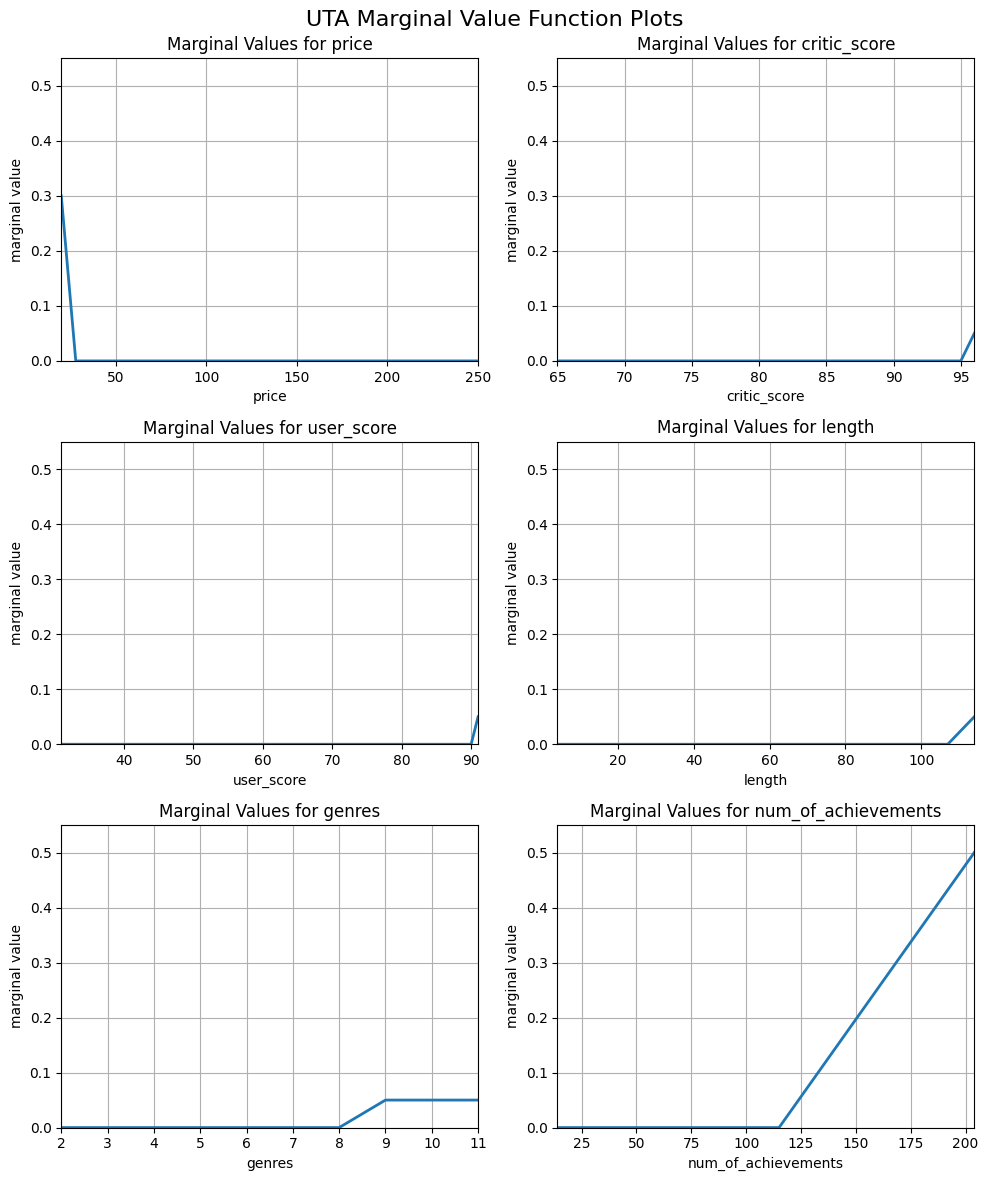

In [8]:
results = solve_UTA(data, criteria_types, revised_preferences)

Ranking of alternatives according to values calculated using the defined marginal value functions.

In [9]:
results

[('Vampire_Survivors', 0.84998),
 ('Skyrim', 0.15003),
 ('Hollow_Knight', 0.10001),
 ('Hades', 0.05003),
 ("Assassin's_Creed_Unity", 0.05002),
 ('Terraria', 0.05001),
 ("Baldur's_Gate_3", 0.05001),
 ('Dark_Souls:_Remastered', 0.05),
 ('Dark_Souls_III', 0.05),
 ('Rust', 0.05),
 ('Ori_and_the_Will_of_the_Wisps', 0.05),
 ('The_Forest', 0.05),
 ('Portal_2', 4e-05),
 ('Inside', 4e-05),
 ('Dishonored', 2e-05),
 ('Dying_Light', 2e-05),
 ('The_Sims_3', 2e-05),
 ('Dave_the_Diver', 1e-05),
 ('Teardown', 1e-05),
 ('Enter_the_Gungeon', 1e-05),
 ('Trials_Fusion', 1e-05),
 ('Titan_Souls', 1e-05),
 ('Subnautica', 0.0),
 ('Payday_3', 0.0),
 ('Kao_the_Kangaroo', 0.0)]

In [15]:
def admit_indifference(results):
    '''
    Find which alternatives have the same score and concatenate their names, with seperation denoted by the | sign.

    Parameters:
        results(List): results from the UTA method.
    '''
    concatenated_results = []
    current_score = None
    current_names = []
    for name, score in results:
        if score == current_score:
            current_names.append(name)
        else:
            if current_score is not None:
                concatenated_results.append((" | ".join(current_names), current_score))
            current_score = score
            current_names = [name]
    if current_score is not None:
        concatenated_results.append((" | ".join(current_names), current_score))
    return concatenated_results

In [11]:
new_results = admit_indifference(results)
new_results

[('Vampire_Survivors', 0.84998),
 ('Skyrim', 0.15003),
 ('Hollow_Knight', 0.10001),
 ('Hades', 0.05003),
 ("Assassin's_Creed_Unity", 0.05002),
 ("Terraria | Baldur's_Gate_3", 0.05001),
 ('Dark_Souls:_Remastered | Dark_Souls_III | Rust | Ori_and_the_Will_of_the_Wisps | The_Forest',
  0.05),
 ('Portal_2 | Inside', 4e-05),
 ('Dishonored | Dying_Light | The_Sims_3', 2e-05),
 ('Dave_the_Diver | Teardown | Enter_the_Gungeon | Trials_Fusion | Titan_Souls',
  1e-05),
 ('Subnautica | Payday_3 | Kao_the_Kangaroo', 0.0)]

### UTA Results Description 2

As can be seen, ranking produced by UTA reflects the preferences defined earlier by the DM, furthermore, the values produced by the method can serve as additional information for the DM, which can also be a positive when it comes to this method.

When it comes to the marginal value functions, it is interesting to see, that in some cases the functions managed to reflect our expectations, for example with price being relatively important and showing high preference for very cheap games. Another positive is that genres ends up being important only past a certain threshold, which also seems appropriate. On the other hand, some aspects were very unexpected like the importance of the number of achievements.
Additionally, there are some alternatives with very high comprehensive value and many games with either very low values or with very small differences between them, which could lead to problems of interpretability and may be against the wishes of the DM. However, these problems are more likely to be caused by the dataset and defined preferences than by the method itself.

### Comparison with PROMETHEE II Results

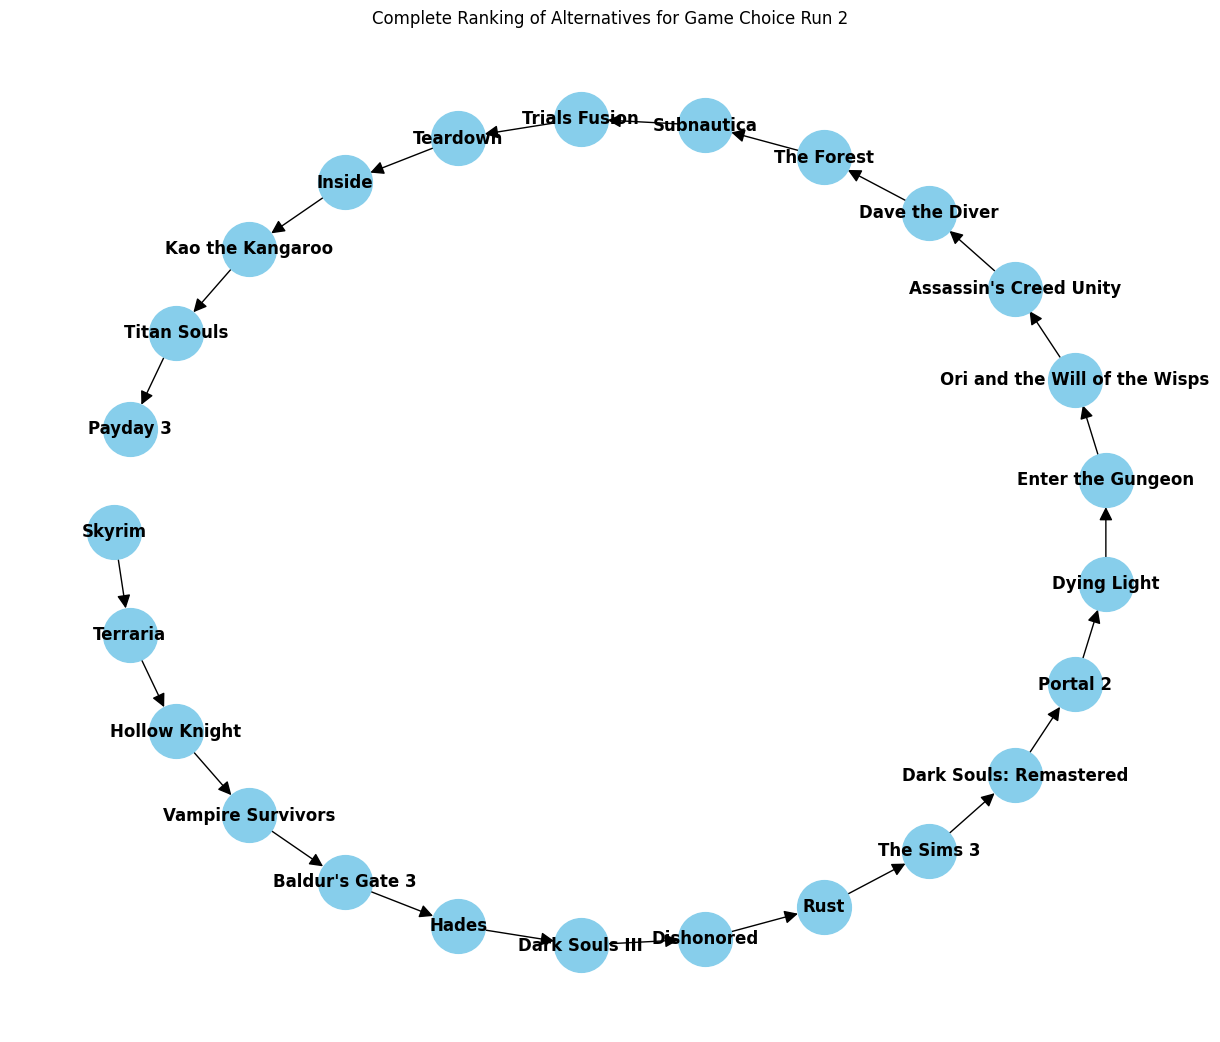

In [12]:
Image(filename='Promethee_II_results.png')

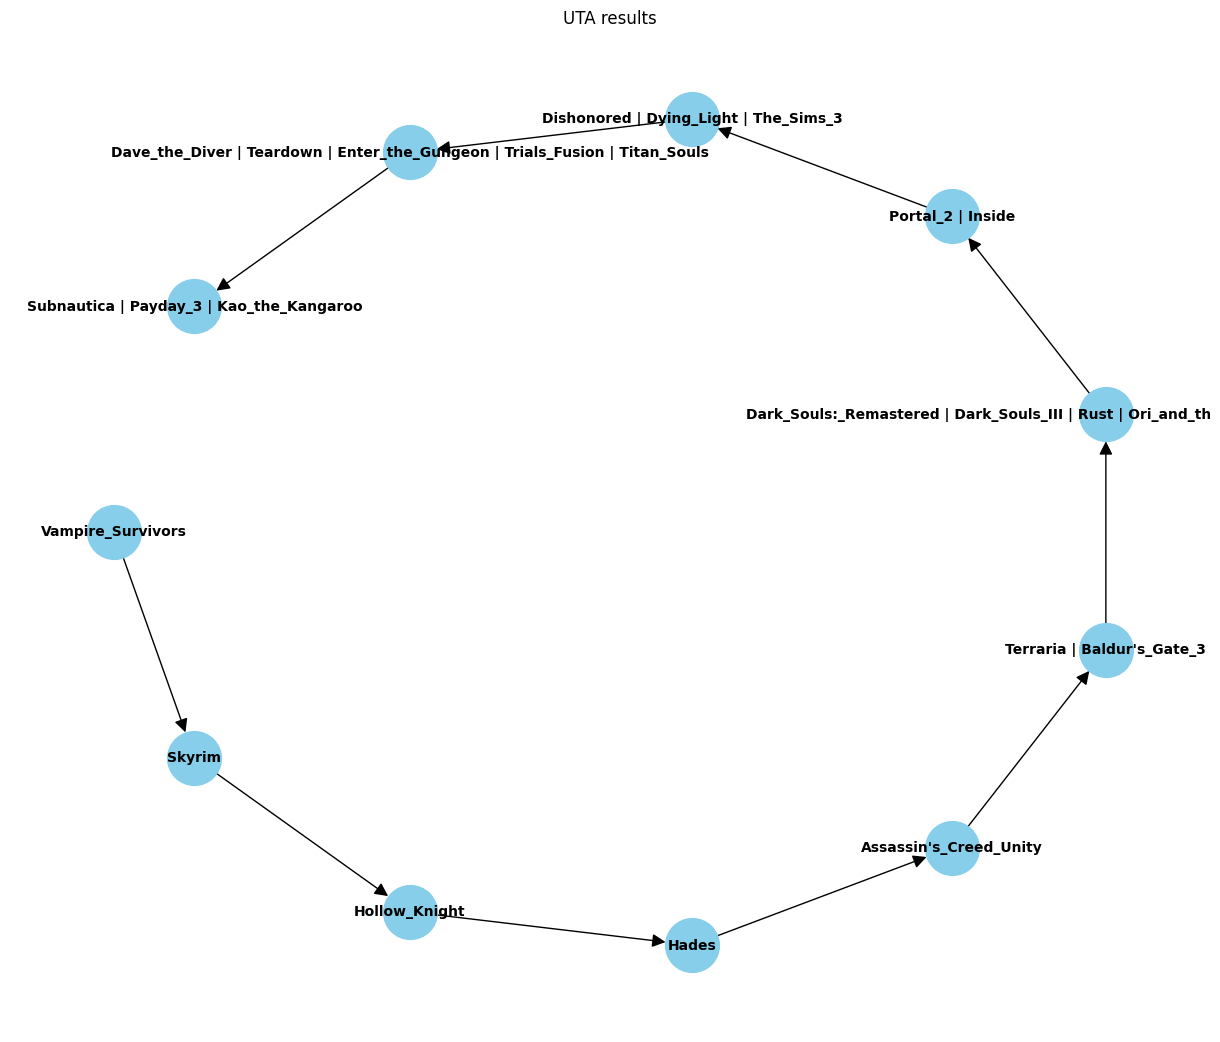

In [14]:
nodes = [item[0] for item in new_results]

G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in range(len(nodes) - 1):
    G.add_edge(nodes[i], nodes[i+1])
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight='bold', arrowsize=20)
plt.title('UTA results')
plt.show()

The comparison with PROMETHEE II method reveals that although the methods differ in the top-ranking alternative, when taking into account a few of the top ranking alternatives, the values end-up being relatively similar. With the main difference being the addition of Assasin's Creed Unity towards the top, but this was probably caused by the artifical injection of it between Dark Souls Remastered and Terraria to cause the inconsistencies necessary to show the working of the algorithm in the earlier sections. Lowest-ranking alternatives also seem similar in both cases, however it must be said that UTA admits many more indifferences between alternatives than other tested methods.

In general, Skyrim seems to achieve very high ranking regardless of method, which seems to have been caused by the high number of trophies, very long play-time and very good reviews from both users and critics, placing it among the favourites among all considered alternatives regardless of the exact method.